# Notebook projet Spark - Erwan MEIGNEN

#Prédiction des désabonnements d'un opérateur télécom

**Prérequis**

In [1]:
!pip install pyspark

In [2]:
!curl -O https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  947k  100  947k    0     0  2688k      0 --:--:-- --:--:-- --:--:-- 2684k


**Chargement des données**

In [3]:
from pyspark.sql import SparkSession

# Création de la session
spark = SparkSession.builder.appName("ChurnPrediction").getOrCreate()

# Chargement des données
df = spark.read.csv("Telco-Customer-Churn.csv", header=True, inferSchema=True)

# Affichage des premières lignes et du schéma
df.show(5)
df.printSchema()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|            0|    Yes|        No|     1|          No|No phone service|            DSL|            No|         Yes|              No|         No|    

**Nettoyage des données**

In [4]:
from pyspark.sql.functions import col, when

# 1. Correction : on gère l'espace " " AVANT de caster
# "Si TotalCharges est un espace, mettre Null, sinon garder la valeur et caster en double"
df_clean = df.withColumn("TotalCharges",
                         when(col("TotalCharges") == " ", None)
                         .otherwise(col("TotalCharges"))
                         .cast("double"))

# 2. Suppression des valeurs manquantes (les Null qu'on vient de créer)
df_clean = df_clean.na.drop(subset=["TotalCharges"])

# 3. Suppression de l'identifiant (inutile pour le ML)
df_clean = df_clean.drop("customerID")

# 4. Conversion de la cible 'Churn' en binaire (1=Yes, 0=No)
df_clean = df_clean.withColumn("Label", when(col("Churn") == "Yes", 1).otherwise(0)).drop("Churn")

# Vérification
df_clean.printSchema()
print(f"Nombre de lignes restantes : {df_clean.count()}")
df_clean.show(5)

root
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Label: integer (nullable = false)

Nombre de lignes restantes : 7032
+------+-------------+-------+----------+------+------------+----------------+---------

**Définition des jeux d'entraînement/test**

In [5]:
# On sépare en 80% d'entraînement et 20% de test
# Le seed=42 permet de toujours avoir le même découpage si on relance
train_data, test_data = df_clean.randomSplit([0.8, 0.2], seed=42)

print(f"Taille du jeu d'entraînement : {train_data.count()}")
print(f"Taille du jeu de test : {test_data.count()}")

print("\nDistribution de la cible (Label) dans le jeu d'entraînement :")
train_data.groupBy("Label").count().show()

Taille du jeu d'entraînement : 5690
Taille du jeu de test : 1342

Distribution de la cible (Label) dans le jeu d'entraînement :
+-----+-----+
|Label|count|
+-----+-----+
|    1| 1526|
|    0| 4164|
+-----+-----+



**Mise en place du pipeline**

In [6]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

# 1. Identification automatique des colonnes
cat_cols = [c for (c, t) in df_clean.dtypes if t == "string"] # Ex: 'gender', 'Partner'...
num_cols = [c for (c, t) in df_clean.dtypes if t != "string" and c != "Label"] # Ex: 'tenure', 'MonthlyCharges'

print(f"Colonnes catégorielles ({len(cat_cols)}) : {cat_cols}")
print(f"Colonnes numériques ({len(num_cols)}) : {num_cols}")

# 2. Construction dynamique des stages de la Pipeline
stages = []

for col_name in cat_cols:
    # Indexation : Transforme "Yes" en 0, "No" en 1
    indexer = StringIndexer(inputCol=col_name, outputCol=col_name + "_idx")
    # One-Hot Encoding : Transforme 0 en [1, 0]
    encoder = OneHotEncoder(inputCol=col_name + "_idx", outputCol=col_name + "_vec")
    stages += [indexer, encoder]

# 3. Assemblage final en un seul vecteur 'features'
# On concatène les vecteurs encodés (_vec) et les variables numériques brutes
assembler_inputs = [c + "_vec" for c in cat_cols] + num_cols
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")
stages += [assembler]

# 4. Création et application de la pipeline
pipeline_preprocessing = Pipeline(stages=stages)

# On 'fit' (apprend) sur le train set uniquement pour éviter la fuite de données
pipeline_model = pipeline_preprocessing.fit(train_data)

# On transforme les deux datasets
train_transformed = pipeline_model.transform(train_data)
test_transformed = pipeline_model.transform(test_data)

print("\nPipeline terminée. Voici à quoi ressemble le vecteur 'features' pour le modèle :")
train_transformed.select("features", "Label").show(5, truncate=False)

Colonnes catégorielles (15) : ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Colonnes numériques (4) : ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

Pipeline terminée. Voici à quoi ressemble le vecteur 'features' pour le modèle :
+---------------------------------------------------------------------------------------------------------------+-----+
|features                                                                                                       |Label|
+---------------------------------------------------------------------------------------------------------------+-----+
|(30,[1,2,7,8,10,12,14,16,18,20,25,27,28,29],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,25.25,25.25])     |0    |
|(30,[1,2,7,8,10,12,14,16,18,20,23,27,28,29],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.

**Entraînement d'un modèle linéaire (Logistic Regression)**



In [7]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# 1. Instanciation et Entraînement
# On utilise la colonne 'features' créée par la pipeline et la cible 'Label'
lr = LogisticRegression(featuresCol="features", labelCol="Label", maxIter=10)
lr_model = lr.fit(train_transformed)

# 2. Prédiction sur le jeu de test
predictions = lr_model.transform(test_transformed)

# Petit aperçu des résultats (Probabilités vs Réalité)
print("Aperçu des prédictions :")
predictions.select("Label", "prediction", "probability").show(5, truncate=False)

# 3. Évaluation
# Evaluator pour l'AUC (discrimination du modèle)
evaluator_auc = BinaryClassificationEvaluator(labelCol="Label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = evaluator_auc.evaluate(predictions)

# Evaluator pour l'Accuracy (juste pour info)
evaluator_acc = MulticlassClassificationEvaluator(labelCol="Label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator_acc.evaluate(predictions)

print(f"--- RÉSULTATS ---")
print(f"Accuracy : {accuracy:.2%}")
print(f"AUC (Area Under ROC) : {auc:.4f}")

Aperçu des prédictions :
+-----+----------+----------------------------------------+
|Label|prediction|probability                             |
+-----+----------+----------------------------------------+
|0    |0.0       |[0.5084640418657318,0.4915359581342682] |
|1    |1.0       |[0.49557979945941133,0.5044202005405887]|
|0    |0.0       |[0.7417804810891179,0.25821951891088213]|
|0    |0.0       |[0.6397319228410928,0.3602680771589072] |
|1    |0.0       |[0.6140745989098935,0.38592540109010653]|
+-----+----------+----------------------------------------+
only showing top 5 rows
--- RÉSULTATS ---
Accuracy : 80.92%
AUC (Area Under ROC) : 0.8556


**Entraînement d'un modèle non-linéaire (Random Forest)**



In [8]:
from pyspark.ml.classification import RandomForestClassifier

print("Entraînement du Random Forest en cours...")

# 1. Configuration du modèle
# numTrees=100 : on plante 100 arbres de décision
rf = RandomForestClassifier(featuresCol="features", labelCol="Label", numTrees=100, seed=42)

# 2. Entraînement (Fit)
rf_model = rf.fit(train_transformed)

# 3. Prédiction (Transform)
predictions_rf = rf_model.transform(test_transformed)

# 4. Évaluation
auc_rf = evaluator_auc.evaluate(predictions_rf)
accuracy_rf = evaluator_acc.evaluate(predictions_rf)

print(f"--- RÉSULTATS RANDOM FOREST ---")
print(f"Accuracy : {accuracy_rf:.2%}")
print(f"AUC       : {auc_rf:.4f}")
print(f"Gain vs Logistic Regression : {auc_rf - 0.8556:.4f}")

Entraînement du Random Forest en cours...
--- RÉSULTATS RANDOM FOREST ---
Accuracy : 79.58%
AUC       : 0.8497
Gain vs Logistic Regression : -0.0059


**Interprétabilité**

                              Variable  Importance
20         Contract_vec_Month-to-month    0.244016
27                              tenure    0.198234
14                  TechSupport_vec_No    0.116408
8                OnlineSecurity_vec_No    0.108418
29                        TotalCharges    0.055753
6      InternetService_vec_Fiber optic    0.054265
28                      MonthlyCharges    0.046543
23  PaymentMethod_vec_Electronic check    0.038128
21               Contract_vec_Two year    0.031643
10                 OnlineBackup_vec_No    0.026132


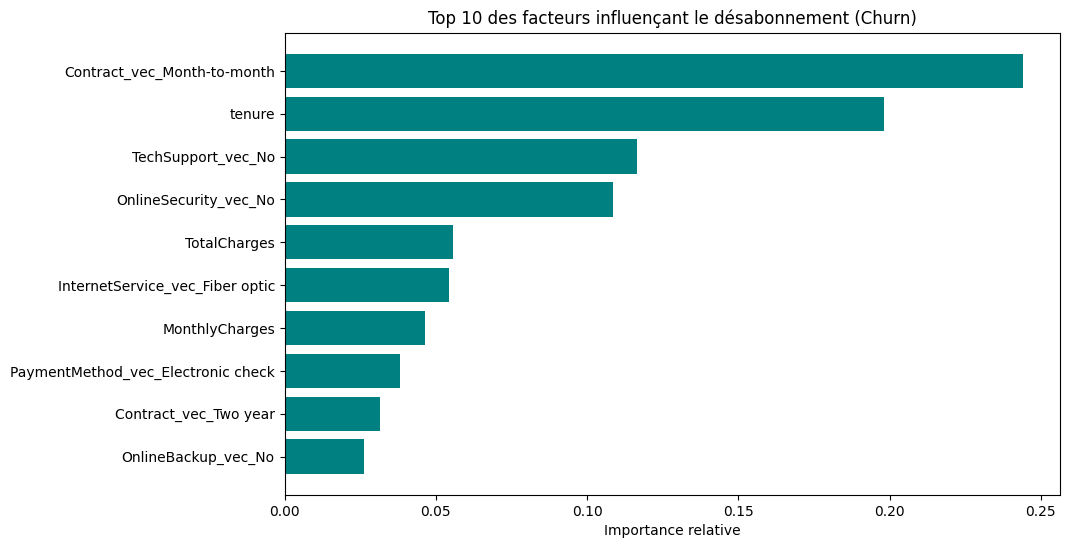

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Récupération des importances brutes du modèle
importances = rf_model.featureImportances

# 2. Récupération des noms des variables depuis les métadonnées de la colonne 'features'
# C'est nécessaire car le VectorAssembler a mélangé toutes les colonnes
attrs = train_transformed.schema["features"].metadata["ml_attr"]["attrs"]

# On combine les attributs numériques et binaires (OneHotEncoded)
features_list = []
# Ajout des variables numériques
if "numeric" in attrs:
    features_list += attrs["numeric"]
# Ajout des variables binaires
if "binary" in attrs:
    features_list += attrs["binary"]

# On trie par index pour être sûr que ça matche avec le vecteur d'importances
features_list.sort(key=lambda x: x["idx"])
feature_names = [x["name"] for x in features_list]

# 3. Création d'un DataFrame Pandas pour l'affichage
df_importance = pd.DataFrame({
    "Variable": feature_names,
    "Importance": importances.toArray()
}).sort_values(by="Importance", ascending=False)

print(df_importance.head(10))

# 4. Visualisation Graphique
plt.figure(figsize=(10, 6))
plt.barh(df_importance["Variable"][:10][::-1], df_importance["Importance"][:10][::-1], color='teal')
plt.title("Top 10 des facteurs influençant le désabonnement (Churn)")
plt.xlabel("Importance relative")
plt.show()